In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

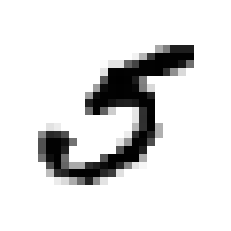

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
y[36000]

5

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96085
0.9613
0.96435


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96085, 0.9613 , 0.96435])

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9119 , 0.9111 , 0.90595])

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
confusion_matrix(y_train_5, y_train_pred)

array([[53613,   966],
       [ 1304,  4117]], dtype=int64)

In [20]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
precision_score(y_train_5, y_train_pred)

0.8099547511312217

In [22]:
recall_score(y_train_5, y_train_pred)

0.7594539752813134

In [23]:
f1_score(y_train_5, y_train_pred)

0.7838918507235338

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2543.88955223])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")
y_scores

array([-14932.28804081, -14067.15388152,    617.99564151, ...,
        -5759.23270717, -24842.29108735, -21972.45561165])

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

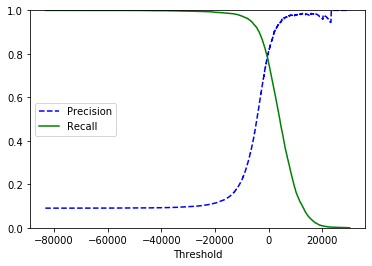

In [30]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
y_train_pred_90 = (y_scores > 6000)
precision_score(y_train_5, y_train_pred_90)

0.9663551401869159

In [32]:
recall_score(y_train_5, y_train_pred_90)

0.38147943183914407

In [33]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

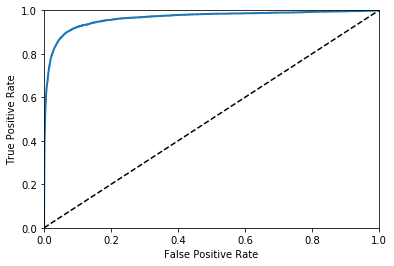

In [35]:
plot_roc_curve(fpr, tpr)
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores)

0.9647768586901235

In [37]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [38]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

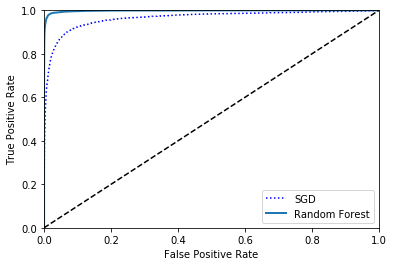

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.998204843183958

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-13989.88504234, -29130.43875111,  -6829.2822211 ,
         -1651.52965242, -13955.18648866,   1796.15994422,
        -19671.54482998, -16642.00309593, -12807.63031373,
        -22724.68217091]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [45]:
sgd_clf.classes_[5]

5

In [46]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [47]:
len(ovo_clf.estimators_)

45

In [48]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [49]:
forest_clf.predict_proba([some_digit])

array([[0.02, 0.  , 0.  , 0.09, 0.  , 0.86, 0.  , 0.02, 0.  , 0.01]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8876, 0.8965, 0.8708])

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90045, 0.8963 , 0.9075 ])

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5604,    0,   14,    8,    8,   38,   30,    5,  216,    0],
       [   1, 6420,   46,   25,    4,   42,    4,    8,  181,   11],
       [  26,   29, 5252,   97,   73,   24,   75,   36,  333,   13],
       [  24,   21,  117, 5239,    1,  212,   28,   45,  376,   68],
       [   9,   15,   42,   13, 5249,    8,   39,   20,  278,  169],
       [  29,   21,   31,  160,   54, 4486,   78,   18,  481,   63],
       [  28,   18,   50,    0,   42,   89, 5562,    4,  125,    0],
       [  21,   13,   56,   26,   48,   13,    4, 5712,  153,  219],
       [  13,   61,   45,   87,    2,  133,   33,    9, 5424,   44],
       [  24,   22,   30,   58,  130,   40,    1,  172,  335, 5137]],
      dtype=int64)

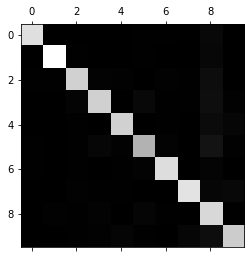

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.46142158e-01, 0.00000000e+00, 2.36366706e-03, 1.35066689e-03,
        1.35066689e-03, 6.41566774e-03, 5.06500084e-03, 8.44166807e-04,
        3.64680061e-02, 0.00000000e+00],
       [1.48323939e-04, 9.52239691e-01, 6.82290122e-03, 3.70809849e-03,
        5.93295758e-04, 6.22960546e-03, 5.93295758e-04, 1.18659152e-03,
        2.68466330e-02, 1.63156333e-03],
       [4.36388050e-03, 4.86740517e-03, 8.81503860e-01, 1.62806311e-02,
        1.22524337e-02, 4.02819738e-03, 1.25881168e-02, 6.04229607e-03,
        5.58912387e-02, 2.18194025e-03],
       [3.91453270e-03, 3.42521611e-03, 1.90833469e-02, 8.54509868e-01,
        1.63105529e-04, 3.45783722e-02, 4.56695482e-03, 7.33974882e-03,
        6.13276790e-02, 1.10911760e-02],
       [1.54056830e-03, 2.56761383e-03, 7.18931873e-03, 2.22526532e-03,
        8.98493667e-01, 1.36939404e-03, 6.67579596e-03, 3.42348511e-03,
        4.75864430e-02, 2.89284492e-02],
       [5.34956650e-03, 3.87382402e-03, 5.71850212e-03, 2.95148497e-02,
   

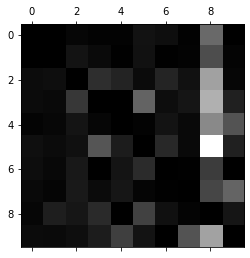

In [55]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [56]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

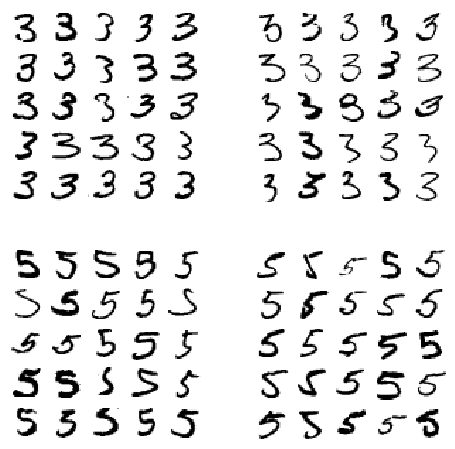

In [57]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [58]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9770363378577245

In [61]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod)
plot_digit(clean_digit)

In [ ]:
X_test_mod[:5000]